````
AESM1450 - Geophysical Prospecting  -- Controlled-Source ElectroMagnetic (CSEM) Modelling
````
# A. Interactive GUI

An example how you can build an interactive GUI to play around.

In [1]:
import empymod
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import FloatSlider, interact

In [2]:
%matplotlib notebook
plt.style.use('ggplot')

In [3]:
w_res = FloatSlider(min=0.01, max=100.0, step=0.1, value=50, continuous_update=False) # Target resistivity
w_thi = FloatSlider(min=10, max=500, step=10, value=100, continuous_update=False)     # Target thickness
w_dep = FloatSlider(min=500, max=3000, step=50, value=2000, continuous_update=False)  # Target depth
w_frq = FloatSlider(min=-2, max=1, step=0.1, value=-1, continuous_update=False)       # log10 frequency

In [4]:
# Acquisition parameters
off = np.arange(5, 101)*100
inp = {
    'src': [0, 0, -950, 0, 0],
    'rec': [off, np.zeros(off.shape), -1000, 0, 0],  # Receiver dipoles [x=off, y=0, z=300; azimuth=0, dip=0]
    'htarg': {'pts_per_dec': -1},
    'verb': 1
}

# Define background model
bg_dep = [0, -1000]
bg_res = [2e14, 0.3, 1]

<IPython.core.display.Javascript object>


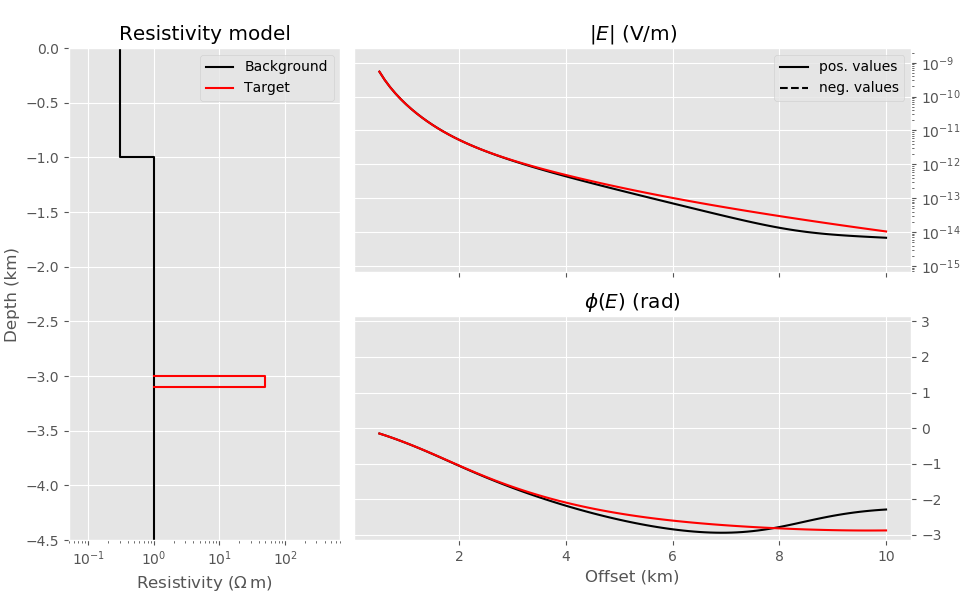

In [5]:
fig = plt.figure(figsize=(9.8, 6), num='Interactive modeling with empymod')
plt.subplots_adjust(left=0.07, right=.93, bottom=0.1, top=.92, wspace=.05)

bg_em = empymod.bipole(depth=bg_dep, res=bg_res, freqtime=10**w_frq.value, **inp)

# 1. Plot resistivity model; initialize target with background
ax1 = plt.subplot2grid((2, 3), (0, 0), rowspan=2)
ax1.set_title('Resistivity model')
bgres = np.r_[bg_res[1], bg_res[1:], bg_res[2]]
bgdep = np.r_[bg_dep, bg_dep[1], -4500]/1000
ax1.semilogx(bgres, bgdep, 'k', label='Background')
ax1.semilogx(bgres, bgdep, 'r', label='Target')
ax1.set_xlim([.05, 700])
ax1.set_ylim([-4.5, 0])
ax1.legend()
ax1.set_ylabel('Depth (km)')
ax1.set_xlabel(r'Resistivity ($\Omega\,$m)')

# 2. Plot amplitude; initialize target with background
ax2 = plt.subplot2grid((2, 3), (0, 1), colspan=2)
ax2.set_title(r'$|E|$ (V/m)')
ax2.semilogy(off/1000, np.where(bg_em.amp >= 0, bg_em.amp, np.nan), 'k', label='pos. values')
ax2.semilogy(off/1000, np.where(bg_em.amp < 0, -bg_em.amp, np.nan), 'k--', label='neg. values')
ax2.semilogy(off/1000, np.where(bg_em.amp >= 0, bg_em.amp, np.nan), 'r')    # Positive values with solid line
ax2.semilogy(off/1000, np.where(bg_em.amp < 0, -bg_em.amp, np.nan), 'r--')  # Negative values with dashed line
ax2.set_xticklabels([])
ax2.yaxis.tick_right()
ax2.legend()
ax2.set_ylim([min(bg_em.amp)/10, max(bg_em.amp)*5])

# 3. Plot phase; initialize target with background
ax3 = plt.subplot2grid((2, 3), (1, 1), colspan=2)
ax3.set_title(r'$\phi(E)$ (rad)')
ax3.plot(off/1000, np.angle(bg_em), 'k')
ax3.plot(off/1000, np.angle(bg_em), 'r')
ax3.set_xlabel('Offset (km)')
ax3.yaxis.tick_right()
ax3.set_ylim([-np.pi, np.pi])

# 4. Define function in which we update the target response
def calc_em(resistivity, depth, thickness, log10freq):
    # Update target depth and resistivity with input
    tg_dep = np.r_[bg_dep, bg_dep[-1]-depth, bg_dep[-1]-(depth+thickness)]
    tg_res = np.r_[bg_res, resistivity, bg_res[2]]

     # Re-calculate the response
    tg_em = empymod.bipole(depth=tg_dep, res=tg_res, freqtime=10**log10freq, **inp)
    bg_em = empymod.bipole(depth=bg_dep, res=bg_res, freqtime=10**log10freq, **inp)

    # Update model and response in plot
    ax1.lines[1].set_xdata([bg_res[2], resistivity, resistivity, bg_res[2]])
    ax1.lines[1].set_ydata(bg_dep[-1]/1000 -
                           np.r_[depth, depth, depth + thickness, depth + thickness]/1000)
    
    ax2.lines[0].set_ydata(np.where(bg_em.amp >= 0, bg_em.amp, np.nan))  # Positive values with solid line
    ax2.lines[1].set_ydata(np.where(bg_em.amp < 0, -bg_em.amp, np.nan))  # Negative values with dashed line
    ax2.lines[2].set_ydata(np.where(tg_em.amp >= 0, tg_em.amp, np.nan))  # Positive values with solid line
    ax2.lines[3].set_ydata(np.where(tg_em.amp < 0, -tg_em.amp, np.nan))  # Negative values with dashed line
    ax2.set_ylim([min(bg_em.amp)/10, max(bg_em.amp)*5])  # Doesn't seem to update...
    
    ax3.lines[0].set_ydata(np.angle(bg_em))
    ax3.lines[1].set_ydata(np.angle(tg_em))
    
    plt.draw()

In [6]:
fwgt = interact(calc_em, resistivity=w_res, depth=w_dep, thickness=w_thi, log10freq=w_frq)

interactive(children=(FloatSlider(value=50.0, continuous_update=False, description='resistivity', min=0.01), F…

In [7]:
empymod.Report()

--------------------------------------------------------------------------------
  Date: Wed Feb 26 14:34:42 2020 CET

                OS : Linux
            CPU(s) : 4
           Machine : x86_64
      Architecture : 64bit
               RAM : 7.7 GB
       Environment : Jupyter

  Python 3.7.6 (default, Jan  8 2020, 19:59:22)  [GCC 7.3.0]

             numpy : 1.18.1
             scipy : 1.4.1
             numba : 0.48.0
           empymod : 1.10.6.dev5+gfc91021
           IPython : 7.12.0
        matplotlib : 3.1.3

  Intel(R) Math Kernel Library Version 2020.0.0 Product Build 20191122 for
  Intel(R) 64 architecture applications
--------------------------------------------------------------------------------